creating rain on snow files to be used as Canrcm4 datasets the usual way 

In [16]:
import xarray as xr
import os
import re
import glob

In [2]:
# import config
import tomllib as tomli
with open(r"C:\Users\CAMG038492\Code\Climatology\config.toml","rb") as f:
    conf = tomli.load(f) # Loads configuration settings from a TOML file.

datahome = conf['paths']['datahome']
originalinput = conf['paths']['originalinput'] # Local path template where downloaded files are stored. Placeholders **p and **s refer to parameter and scenario, respectively. Loads from config.toml.

testpath = r"C:\Data\prsn\historical\originals\prsn_NAM-44_CCCma-CanESM2_historical_r1i1p1_CCCma-CanRCM4_r2_day_19500101-19501231.nc"

file infrastructure is set up so that each of the three climate parameters used, pr, prsn, and snd are from the same dataset with the same folder and datastructure, allowing one to be opened means that a simple string replace can find the others, this function places each into a dictionary for later use

In [3]:
def matchandopentimestamps(filepath:str, para1:str, paras2:str|list) -> xr.Dataset | dict | None:
    if isinstance(paras2, str):
        if para1 == paras2: pass
        else:
            newpath = filepath.replace(para1, paras2)
            outds = xr.open_dataset(newpath)
            return outds
    if isinstance(paras2, list):
        d = {}
        d[para1] = xr.open_dataset(filepath)
        for p in paras2:
            if para1 == p: pass
            else:
                newpath = filepath.replace(para1, p)
                d[p] = xr.open_dataset(newpath)
        return d

listing out the things to iterate through
choosing prsn as the folder to search

In [8]:
scenlist = ['historical','rcp45','rcp85']
paralist = ['pr','prsn','snd']
startpara = 'prsn'

createros: does the actual math to create the rain on snow dataset 

need to open pr, prsn, and snd and align the datasets

rain is calculated as pr-prsn, then dropped if any values ended up negative (they were on the order of 10e-9 mostly)
pr, prsn, and rain are all in flux units kg m-2 s-1

filtering to snow depth > 1.0 cm (0.01m)
rosamt is the amount of rain that falls on snow > 1cm
rosbool is the presence of rain > 0.000001 falling on snow > 1cm, to smoothen out for excessively low subtraction errors during the flux process


In [5]:
def createros(dictfiles):
    baseattrs = dictfiles['pr'].attrs

    # opening and aligning data
    pr = dictfiles['pr']
    prsn = dictfiles['prsn']
    prsnrenamed = prsn.rename({'prsn':'pr'}) # just for the sake of subtracting, need to rename the data variable
    snd = dictfiles['snd']
    pr,prsnrenamed,snd = xr.align(pr, prsnrenamed, snd, join = 'inner')

    # calculating rain as pr-prsn
    rain = pr.pr-prsnrenamed.pr
    rainpos = rain.where(rain>0, other = 0)
    rainpos.attrs['units'] = 'kg m-2 s-1'
    SETrain = rainpos.to_dataset(name = 'ros')

    # querying to where snow depth is > 1.0 cm
    SETros = SETrain.where(snd['snd']>0.01, drop=False).fillna(0.0)
    #SETros["ros_bool"] = xr.where(SETros["ros"] > 0.000001, 1., 0.)
    SETros.attrs = baseattrs | {"wsp_ros": "ros: (pr-prsn) values in original flux units kg m-2 s-1 filtered to where snow depth > 0.01 m",
                                "wsp_rosbool": "ros_bool: if (pr-prsn) > 0 where snow depth snd > 0.01, 1 for true, 0 for false",
                                "units" : "kg m-2 s-1"}
    return SETros

testing zone to confirm things look okay in plots and attributes

<xarray.Dataset> Size: 119MB
Dimensions:  (time: 365, rlat: 260, rlon: 310)
Coordinates:
  * time     (time) object 3kB 1950-01-01 12:00:00 ... 1950-12-31 12:00:00
  * rlon     (rlon) float64 2kB -33.99 -33.77 -33.55 ... 33.55 33.77 33.99
  * rlat     (rlat) float64 2kB -28.71 -28.49 -28.27 ... 27.83 28.05 28.27
    lon      (rlat, rlon) float64 645kB 232.9 233.1 233.2 ... 336.2 336.5 336.7
    lat      (rlat, rlon) float64 645kB 12.22 12.3 12.38 ... 59.44 59.29 59.13
Data variables:
    ros      (time, rlat, rlon) float32 118MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/26)
    title:                          CanRCM4 model output prepared for CORDEX ...
    institution:                    CCCma (Canadian Centre for Climate Modell...
    institute_id:                   CCCma
    contact:                        cccma_info@ec.gc.ca
    Conventions:                    CF-1.4
    experiment:                     Historical run driven by CCCma-CanESM2
    ...                             ...
    references:                     http://www.cccma.ec.gc.ca/models
    history:                        created: 2012-10-17 16:35:45 by rcm2nc
    data_licence:                   1) GRANT OF LICENCE - The Government of C...
    wsp_ros:                        ros: (pr-prsn) values in original flux un...
    wsp_rosbool:                    ros_bool: if (pr-prsn) > 0 where snow dep...
    units:                          kg m-2 s-1

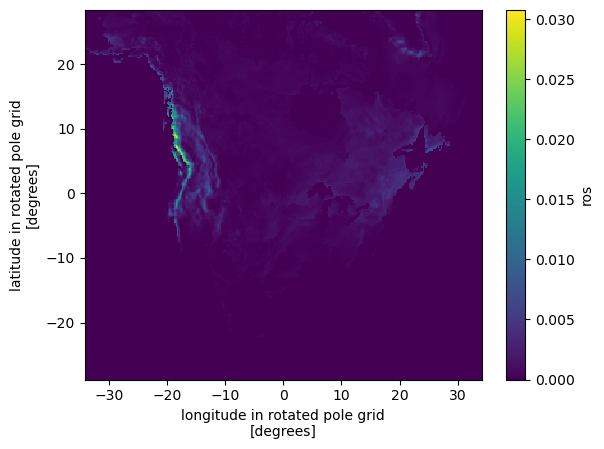

In [7]:
testscen = "historical"
testpath = originalinput.replace("**p", startpara).replace("**s", testscen)
testfile = os.listdir(testpath)[1]
fullpath = os.path.join(testpath,testfile)
td = matchandopentimestamps(fullpath, startpara, paralist)
tros = createros(td)
tros.ros.sum(dim = 'time').plot()
tros

iterating through each of the files, stored in parameter/scenario subfolders, and exporting to new ros folder

In [ ]:
def iterate(startpara = startpara, scenlist = scenlist, export = False):
    for scen in scenlist:
        path = originalinput.replace("**p", startpara).replace("**s", scen)
        for file in os.listdir(path):
            fullpath = os.path.join(path,file)
            if not os.path.isdir(fullpath):
                d = matchandopentimestamps(fullpath, startpara, paralist)
                ros = createros(d)

                # export zone
                if export:
                    newpath = path.replace(startpara,"ros")
                    newname = file.replace(startpara,"ros")
                    newfullpath = fullpath.replace(startpara,"ros")
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)
                    ros.to_netcdf(newfullpath)
                    print(f"ros dataset saved to {newfullpath}")
                #ros.plot()

In [18]:
iterate(startpara, scenlist, export = True)

ros dataset saved to C:\Data\ros\historical\originals\ros_NAM-22_CCCma-CanESM2_historical_r1i1p1_CCCma-CanRCM4_r2_day_19500101-19501231.nc
ros dataset saved to C:\Data\ros\historical\originals\ros_NAM-22_CCCma-CanESM2_historical_r1i1p1_CCCma-CanRCM4_r2_day_19510101-19551231.nc
ros dataset saved to C:\Data\ros\historical\originals\ros_NAM-22_CCCma-CanESM2_historical_r1i1p1_CCCma-CanRCM4_r2_day_19560101-19601231.nc
ros dataset saved to C:\Data\ros\historical\originals\ros_NAM-22_CCCma-CanESM2_historical_r1i1p1_CCCma-CanRCM4_r2_day_19610101-19651231.nc
ros dataset saved to C:\Data\ros\historical\originals\ros_NAM-22_CCCma-CanESM2_historical_r1i1p1_CCCma-CanRCM4_r2_day_19660101-19701231.nc
ros dataset saved to C:\Data\ros\historical\originals\ros_NAM-22_CCCma-CanESM2_historical_r1i1p1_CCCma-CanRCM4_r2_day_19710101-19751231.nc
ros dataset saved to C:\Data\ros\historical\originals\ros_NAM-22_CCCma-CanESM2_historical_r1i1p1_CCCma-CanRCM4_r2_day_19760101-19801231.nc
ros dataset saved to C:\Dat